# Import

In [1]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline

# Load the data

In [2]:
df = pd.read_csv("https://github.com/pvateekul/2110446_DSDE_2023s2/raw/main/code/Week03_ML/mushroom2020_dataset.csv")
df.head()

,id,label,cap-shape,cap-surface,bruises,odor,gill-attachment,gill-spacing,gill-size,stalk-shape,...,ring-number,ring-type,spore-print-color,population,habitat,cap-color-rate,gill-color-rate,veil-color-rate,stalk-color-above-ring-rate,stalk-color-below-ring-rate
0,1,p,x,s,t,p,f,c,n,e,...,o,p,k,s,u,1.0,3.0,1.0,1.0,1.0
1,2,e,x,s,t,a,f,c,b,e,...,o,p,n,n,g,2.0,3.0,1.0,1.0,1.0
2,3,e,b,s,t,l,f,c,b,e,...,o,p,n,n,m,3.0,1.0,1.0,1.0,1.0
3,4,p,x,y,t,p,f,c,n,e,...,o,p,k,s,u,3.0,1.0,1.0,1.0,1.0
4,5,e,x,s,f,n,f,w,b,t,...,o,e,n,a,g,4.0,3.0,1.0,1.0,1.0


# Drop missing label and other columns

In [3]:
# Drop rows where the label variable is missing
df_clean = df.dropna(subset=['label'])

# Drop the specified variables
variables_to_drop = ['id', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color-rate',
                      'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring',
                      'stalk-color-above-ring-rate', 'stalk-color-below-ring-rate',
                      'veil-color-rate', 'veil-type']
df_clean = df_clean.drop(variables_to_drop, axis=1)

df_clean.head()

,label,cap-shape,cap-surface,bruises,odor,stalk-shape,ring-number,ring-type,spore-print-color,population,habitat,cap-color-rate
0,p,x,s,t,p,e,o,p,k,s,u,1.0
1,e,x,s,t,a,e,o,p,n,n,g,2.0
2,e,b,s,t,l,e,o,p,n,n,m,3.0
3,p,x,y,t,p,e,o,p,k,s,u,3.0
4,e,x,s,f,n,t,o,e,n,a,g,4.0


# Pipelines for Numerical and Categorical Features

In [4]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

num_cols = ['cap-color-rate']
cat_cols = ['cap-shape', 'cap-surface', 'bruises', 'odor', 'stalk-shape', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']

num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler())])

cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot',OneHotEncoder(handle_unknown='ignore'))])

# ColumnTransformer to Apply the Pipeline for Each Column

In [5]:
from sklearn.compose import ColumnTransformer

col_trans = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, num_cols),
    ('cat_pipeline', cat_pipeline, cat_cols)],
    n_jobs=-1)

# Add model to the Pipeline

In [6]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model_pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', model)
])

# Show Pipline

In [7]:
from sklearn import set_config

set_config(display='diagram')
display(model_pipeline)

Pipeline(steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['cap-color-rate']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['cap-shape', 'cap-surface',
                                                   'bruises', 'odor',
                                                   'stalk-shape', 'ring-number',
                                                   'ring-type',
                                                   'spore-print-color',
                                                   'population',
                                                   'habitat'])])),
                ('model', RandomForestClassifier())])

# Train Test Split

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
X = df_clean[num_cols + cat_cols]
y = df_clean['label']
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2020)

# ML Flow setup

In [9]:
# Importing all Libraries
import mlflow
import mlflow.sklearn

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings("ignore")

In [10]:
local_registry = "sqlite:///mlruns.db"
mlflow.set_tracking_uri(local_registry)
experiment_id = mlflow.set_experiment('test_experiment')

def eval_metrics(actual, pred):
    accuracy = accuracy_score(actual, pred)
    return accuracy

def train_model(param_grid, n_splits):

    # Starting the Experiement
    with mlflow.start_run():

        # Model building
        model = GridSearchCV(model_pipeline, param_grid, cv=StratifiedKFold(n_splits), scoring='accuracy')
        model.fit(X_train, y_train)   # Model Training
        y_pred = model.predict(X_test)  # Model Prediction on Testing data
        (accuracy) = eval_metrics(y_test, y_pred)

        print('Accuracy: {:.4f}'.format(accuracy))

        # Logging Parameters
        mlflow.log_param("param_grid", param_grid)
        mlflow.log_param("n_splits", n_splits)

        # Logging Metrics
        mlflow.log_metric("accuracy", accuracy_score(y_test, y_pred))

        # Model Logging
        mlflow.sklearn.log_model(model, 'model')

        return model

2024/02/12 23:19:25 INFO mlflow.tracking.fluent: Experiment with name 'test_experiment' does not exist. Creating a new experiment.


# Train Model

In [11]:
param_grid = {
    'model__criterion':['gini', 'entropy'],
    'model__max_depth': [2, 3, 6],
    'model__min_samples_leaf':[2, 5, 10],
    'model__n_estimators': [100, 200],
    'model__random_state':[2020]
}
n_splits = 5
train_model(param_grid, n_splits)

Accuracy: 0.9965


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('col_trans',
                                        ColumnTransformer(n_jobs=-1,
                                                          transformers=[('num_pipeline',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer()),
                                                                                         ('scale',
                                                                                          StandardScaler())]),
                                                                         ['cap-color-rate']),
                                                                        ('cat_pipeline',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('...
                                                                         ['cap-shape',
                                                                          'cap-surface',
                                                                          'bruises',
                                                                          'odor',
                                                                          'stalk-shape',
                                                                          'ring-number',
                                                                          'ring-type',
                                                                          'spore-print-color',
                                                                          'population',
                                                                          'habitat'])])),
                                       ('model', RandomForestClassifier())]),
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': [2, 3, 6],
                         'model__min_samples_leaf': [2, 5, 10],
                         'model__n_estimators': [100, 200],
                         'model__random_state': [2020]},
             scoring='accuracy')

# Get best model

In [12]:
# Search run id
best_run_df = mlflow.search_runs(order_by=['metrics.accuracy DESC'], max_results=1)
best_run_df

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.accuracy,params.param_grid,params.n_splits,tags.mlflow.log-model.history,tags.mlflow.user,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.runName
0,b7424e2648b54d1c99f72fd4e15461d7,1,FINISHED,/Users/titor/Chula/3-2/datasci/assignment5/mlr...,2024-02-12 16:19:25.866000+00:00,2024-02-12 16:20:02.792000+00:00,0.996531,"{'model__criterion': ['gini', 'entropy'], 'mod...",5,"[{""run_id"": ""b7424e2648b54d1c99f72fd4e15461d7""...",titor,/opt/homebrew/Caskroom/miniforge/base/envs/dat...,LOCAL,dazzling-rook-615


In [13]:
run_id = str(best_run_df.loc[0, 'run_id'])
print('run_id: ', run_id)

run_id = str(best_run_df.loc[0, 'run_id'])
model_uri = f"runs:/{run_id}/model"
print('model_uri: ', model_uri)

run_id:  b7424e2648b54d1c99f72fd4e15461d7
model_uri:  runs:/b7424e2648b54d1c99f72fd4e15461d7/model


In [14]:
# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(model_uri=f"runs:/{run_id}/model")

# Predict on a Pandas DataFrame.
predicted = loaded_model.predict(pd.DataFrame(X_test))

print(classification_report(y_test, predicted, digits=4))

              precision    recall  f1-score   support

           e     0.9906    1.0000    0.9953       421
           p     1.0000    0.9945    0.9973       732

    accuracy                         0.9965      1153
   macro avg     0.9953    0.9973    0.9963      1153
weighted avg     0.9966    0.9965    0.9965      1153



# Model registry

In [15]:
mlflow.register_model(model_uri=model_uri, name="Murshroom")

Successfully registered model 'Murshroom'.
Created version '1' of model 'Murshroom'.


<ModelVersion: aliases=[], creation_timestamp=1707754802944, current_stage='None', description=None, last_updated_timestamp=1707754802944, name='Murshroom', run_id='b7424e2648b54d1c99f72fd4e15461d7', run_link=None, source='/Users/titor/Chula/3-2/datasci/assignment5/mlruns/1/b7424e2648b54d1c99f72fd4e15461d7/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=1>

# Evaluate the model

In [16]:
model_name = 'Murshroom'
model_version = 1

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(model_uri=f"models:/{model_name}/{model_version}")

# Predict on a Pandas DataFrame.
predicted = loaded_model.predict(pd.DataFrame(X_test))

In [17]:
from sklearn.metrics import confusion_matrix, classification_report

# Predict the testing data set
y_pred = loaded_model.predict(X_test)

# Evaluate the model using confusion_matrix and classification_report
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Display the confusion matrix and classification report
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)

Confusion Matrix:
[[421   0]
 [  4 728]]

Classification Report:
              precision    recall  f1-score   support

           e       0.99      1.00      1.00       421
           p       1.00      0.99      1.00       732

    accuracy                           1.00      1153
   macro avg       1.00      1.00      1.00      1153
weighted avg       1.00      1.00      1.00      1153



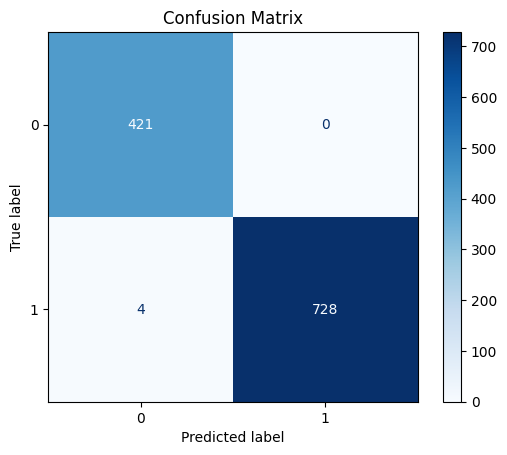

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Display the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues, values_format=".4g")
plt.title('Confusion Matrix')
plt.show()

In [19]:
from sklearn.metrics import f1_score

# Calculate macro F1 score
macro_f1 = f1_score(y_test, y_pred, average='macro')

print("Macro F1 Score:", macro_f1)
print("Rounded Macro F1 Score:", round(macro_f1, 2))

Macro F1 Score: 0.996266070792448
Rounded Macro F1 Score: 1.0


# MLflow UI

In [20]:
!mlflow ui --backend-store-uri sqlite:///mlruns.db

[2024-02-12 23:20:04 +0700] [44155] [INFO] Starting gunicorn 21.2.0
[2024-02-12 23:20:04 +0700] [44155] [INFO] Listening at: http://127.0.0.1:5000 (44155)
[2024-02-12 23:20:04 +0700] [44155] [INFO] Using worker: sync
[2024-02-12 23:20:04 +0700] [44156] [INFO] Booting worker with pid: 44156
[2024-02-12 23:20:04 +0700] [44157] [INFO] Booting worker with pid: 44157
[2024-02-12 23:20:04 +0700] [44158] [INFO] Booting worker with pid: 44158
[2024-02-12 23:20:04 +0700] [44159] [INFO] Booting worker with pid: 44159
^C
[2024-02-12 23:20:18 +0700] [44155] [INFO] Handling signal: int
[2024-02-12 23:20:18 +0700] [44157] [INFO] Worker exiting (pid: 44157)
[2024-02-12 23:20:18 +0700] [44159] [INFO] Worker exiting (pid: 44159)
[2024-02-12 23:20:18 +0700] [44156] [INFO] Worker exiting (pid: 44156)
[2024-02-12 23:20:18 +0700] [44158] [INFO] Worker exiting (pid: 44158)
